In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns 
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from sklearn.gaussian_process import GaussianProcessRegressor
from tanimoto import FastTanimotoKernel

In [2]:
class ChemCalculator(FastTanimotoKernel):
    def __init__(self, data_set):
        super().__init__()
        self.data_set = data_set
        #self.property = property
        self.fingerprint = []
        self.read_set = pd.read_csv(self.data_set)

    def show_data(self):
        print(self.read_set)

    def select_data(self, smiles, property, number_of_data):
        self.read_set = self.read_set[0:number_of_data] # poolsize
        self.data_smiles = self.read_set[smiles]
        self.data_property = self.read_set[property]

        self.data_smiles = self.data_smiles.tolist()
        self.data_property = self.data_property.tolist()
        return self.data_smiles, self.data_property
    
    def convert_smiles_to_fingerprint(self, data_smiles, radius=2, nBits=2048):
        self.molecul = Chem.MolFromSmiles(data_smiles)
        self.fp = AllChem.GetMorganFingerprintAsBitVect(self.molecul, radius=radius, nBits=nBits)
        return self.fp
    
    def matrix_fingerprints(self):
        self.fingerprint = []
        if self.data_smiles:
            self.fingerprint = [self.convert_smiles_to_fingerprint(smile) for smile in self.data_smiles]
        else:
            print("No data SMILES selected. Please use select_data method first.")
    
    def distance_tanimoto(self, i, j, fps = None):
        if fps == None:
            fps = self.fingerprint
        return 1.0 - DataStructs.TanimotoSimilarity(fps[i],fps[j])
    
    def most_diverse_data(self):
        if self.fingerprint:
            self.n_total = len(self.fingerprint)
            self.subset_size = 9000
            self.ids = MaxMinPicker().LazyPick(self.distance_tanimoto,self.n_total,self.subset_size)
            self.ids = list(self.ids)

            self.fingerprint = [self.fingerprint[id] for id in self.ids]
            self.property = [self.data_property[id] for id in self.ids]
            return self.fingerprint
        else:
            print("No fingerprints. Please verify and use matrix_fingerprints().")

    def get_fingerprints(self):
        if not self.fingerprint:
            print("Fingerprint matrix is empty. Please use matrix_fingerprints method first.")
        return self.fingerprint
    
    def gp_train(self):
        if not self.fingerprint or not self.property:
            print("Fingerprint matrix or property data is missing. Please ensure both are available.")
            return None
        self.kernel = FastTanimotoKernel()
        self.gp = GaussianProcessRegressor(kernel=self.kernel,alpha=1e-6, n_restarts_optimizer=10)
        self.gp.fit(self.fingerprint, self.property)
    
    def gp_predict(self, test_smiles):
        self.test_fp = [self.convert_smiles_to_fingerprint(smile) for smile in test_smiles]
        self.X_test = np.array(self.test_fp, dtype=object)
        self.y_pred, self.y_std = self.gp.predict(self.X_test, return_std=True)
        print("Predicted values:", self.y_pred)
        print("Uncertainity:",self.y_std)

    def get_predictions(self):
        return self.y_pred
    
    def get_uncertainty(self):
        return self.y_std
        
    def plot_regression(self, y_true, y_pred, y_std=None, ideal_line=True, cmap="viridis", s=30, alpha=0.9, ax=None, xlabel="Actual", 
                        ylabel="Predicted", title=None, equal_aspect=True, show_stats=True, stats_fmt="{name} = {value:.3f}", add_colorbar=True,):
        
        y_true = np.asarray(y_true).ravel()
        y_pred = np.asarray(y_pred).ravel()

        if y_true.shape != y_pred.shape:
            raise ValueError("y_true and y_pred must have the same shape after ravel().")

        if y_std is not None:
            y_std = np.asarray(y_std).ravel()
            if y_std.shape != y_true.shape:
                raise ValueError("y_std must have the same shape as y_true/y_pred.")

        # Drop non-finite rows
        if y_std is None:
            m = np.isfinite(y_true) & np.isfinite(y_pred)
        else:
            m = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(y_std)

        y_true = y_true[m]
        y_pred = y_pred[m]
        if y_std is not None:
            y_std = y_std[m]

        # Create axis
        if ax is None:
            fig, ax = plt.subplots(figsize=(6.6, 5.6), constrained_layout=True)
        else:
            fig = ax.figure

        # Scatter
        if y_std is None:
            sc = ax.scatter(y_true, y_pred, s=s, alpha=alpha, edgecolor="none", zorder=3)
        else:
            sc = ax.scatter(
                y_true, y_pred,
                c=y_std,
                cmap=cmap,
                s=s,
                alpha=alpha,
                edgecolor="none",
                zorder=3,
            )

        # Reference line y=x over data range
        if ideal_line:
            lo = np.nanmin([y_true.min(), y_pred.min()])
            hi = np.nanmax([y_true.max(), y_pred.max()])
            pad = 0.03 * (hi - lo if hi > lo else 1.0)
            lo -= pad
            hi += pad
            ax.plot([lo, hi], [lo, hi], "--", linewidth=1.8, zorder=1)

        # Stats box
        if show_stats:
            resid = y_true - y_pred
            rmse = np.sqrt(np.mean(resid**2))
            mae = np.mean(np.abs(resid))
            ss_res = np.sum((y_true - y_pred) ** 2)
            ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
            r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

            stats_text = "\n".join([
                stats_fmt.format(name="R²", value=r2),
                stats_fmt.format(name="MAE", value=mae),
                stats_fmt.format(name="RMSE", value=rmse),
            ])
                    # Pick least-crowded corner using medians in parity space
        xmid = np.median(y_true)
        ymid = np.median(y_pred)
        corners = {
            "upper left":  ((y_true < xmid) & (y_pred > ymid)).sum(),
            "upper right": ((y_true > xmid) & (y_pred > ymid)).sum(),
            "lower left":  ((y_true < xmid) & (y_pred < ymid)).sum(),
            "lower right": ((y_true > xmid) & (y_pred < ymid)).sum(),
        }
        loc = min(corners, key=corners.get)

        ax.text(
            0.02 if "left" in loc else 0.98,
            0.98 if "upper" in loc else 0.02,
            stats_text,
            transform=ax.transAxes,
            ha="left" if "left" in loc else "right",
            va="top" if "upper" in loc else "bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="0.5", alpha=0.9),
            zorder=10,
        )

        # Colorbar
        if add_colorbar and (y_std is not None):
            cbar = fig.colorbar(sc, ax=ax, pad=0.02)
            cbar.set_label("Predictive uncertainty (std)")

        # Style
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if title is not None:
            ax.set_title(title)

        ax.grid(True, alpha=0.25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        if equal_aspect:
            ax.set_aspect("equal", adjustable="box")

        return ax

In [3]:
propCal = ChemCalculator("qm9.csv")
propCal.show_data()

            mol_id               smiles          A           B           C  \
0            gdb_1                    C  157.71180  157.709970  157.706990   
1            gdb_2                    N  293.60975  293.541110  191.393970   
2            gdb_3                    O  799.58812  437.903860  282.945450   
3            gdb_4                  C#C    0.00000   35.610036   35.610036   
4            gdb_5                  C#N    0.00000   44.593883   44.593883   
...            ...                  ...        ...         ...         ...   
133880  gdb_133881  C1C2C3C4C5OC14C5N23    3.59483    2.198990    1.904230   
133881  gdb_133882  C1N2C3C2C2C4OC12C34    3.65648    2.142370    1.904390   
133882  gdb_133883  C1N2C3C4C5C2C13CN45    3.67118    2.143140    1.895010   
133883  gdb_133884  C1N2C3C4C5CC13C2C45    3.52845    2.151310    1.865820   
133884  gdb_133885  C1N2C3C4C5OC13C2C45    3.64015    2.217640    1.937930   

            mu  alpha    homo    lumo     gap  ...      zpve   

In [4]:
propCal.select_data(smiles="smiles", property="gap", number_of_data=25000)
propCal.matrix_fingerprints()
propCal.most_diverse_data()
propCal.gp_train()

In [5]:
# Test model
data_test = pd.read_csv("qm9.csv")
smiles_test = data_test["smiles"][15001:16001] # 1000 datos
propCal.gp_predict(smiles_test)

Predicted values: [0.34698321 0.32790003 0.35182536 0.32647419 0.33110484 0.3308
 0.32490002 0.3409     0.31039078 0.31668194 0.32934661 0.32590697
 0.32119998 0.32360002 0.3275     0.28703738 0.2712     0.29741026
 0.26589996 0.29869996 0.2664812  0.27267557 0.27663635 0.30191341
 0.27761678 0.21588813 0.21291503 0.21740004 0.20910474 0.22210001
 0.21208119 0.22861026 0.22529993 0.21770001 0.19580008 0.19540002
 0.2212821  0.2029     0.23129865 0.20689999 0.16380003 0.31147008
 0.29969019 0.28290004 0.33359993 0.30093646 0.30524566 0.29365365
 0.28729048 0.27310004 0.28262376 0.29939996 0.27549523 0.30545016
 0.29605268 0.27425709 0.29480004 0.27899995 0.30229999 0.28562929
 0.30337889 0.26732817 0.31499464 0.29738931 0.30409999 0.28934925
 0.22430005 0.23002079 0.22869657 0.22120002 0.26659997 0.2202
 0.2081574  0.22007332 0.22804793 0.21914489 0.22720002 0.22192971
 0.34786351 0.34579998 0.33806778 0.32744812 0.31679995 0.34153019
 0.31510001 0.32924425 0.32878139 0.30044193 0.32289

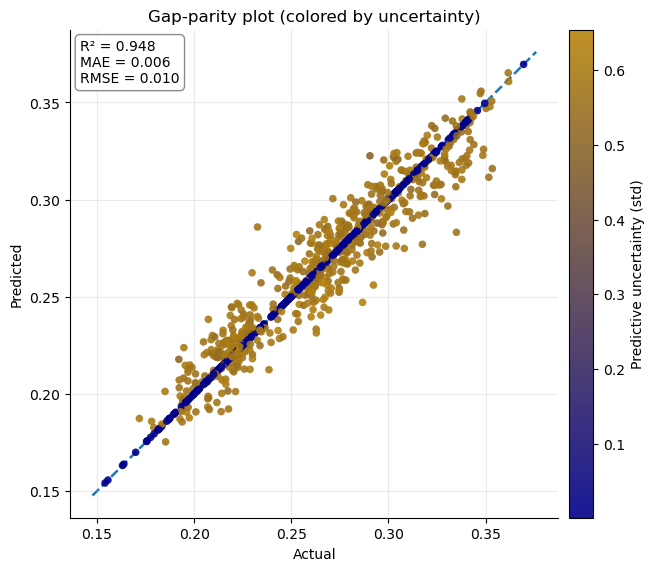

In [7]:
## Puma cmap generator:
cmap_name = 'DarkBlueToDarkGold'
colors = ['#00008B', '#B8860B']

puma_cmap = mcolors.LinearSegmentedColormap.from_list(
    cmap_name, colors, N=256)

propCal.plot_regression(
    list(data_test["gap"][15001:16001]),
    propCal.get_predictions(),
    propCal.get_uncertainty(),
    cmap=puma_cmap,
    title="Gap-parity plot (colored by uncertainty)"
)
plt.show()